In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from utils.data_processing import load_pore_matrices

****
# Problem description
****

Probleme physique:
- Input: grille dans le carré unité avec 0 si pas de pores et 1 si des pores
- Output: density factor qui est le ratio du volume des pores / volume du cube

Problème inverse:
- Input: Density factor
- Output: grille avec 0 ou 1 i.e. distribution jointe de bernoulli

Goal: Il faut apprendre la distribution de la grille (joint bernoulli distributions) conditionnellement au density factor.

Challenges:
- La grille est sparse, donc le modèle a tendence à vouloir apprendre la matrice remplie de 0 ce qui a de grande chances de minimiser la loss. Idée: faire une weighted loss où on focus sur tous les 1 + quelques 0 tirés aléatoirement (negative sampling)
- Les 1 adjacents sont probablement un même pore mais plus gros. Est-il important de calculer ces gros pores ainsi que leur volume, ou alors juste l'agencement de 1 suffit?

Idée principale:
- GAN: Espace latent (inputs), serait tiré dans la distribution des density factors + outputs = matries reconstruites
- Autre idée: Faire un U-net ou VAE où la distribution à priori = la distribution du density factor (1D). L'encoder apprendrait le problème physiaue, alors que le décoder le problème inverse. 
- Comme l'input est une matrice en 3D, et qu'on cherche les patterns de cette matrice, on aurait envie d'utiliser des CNN dans l'encoder et le decoder. 

****
# Load data
****

In [2]:
import os
import numpy as np

data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

data_dict, grid_dict, densities_dict = load_pore_matrices(npy_files)


****
# Visualisation
****

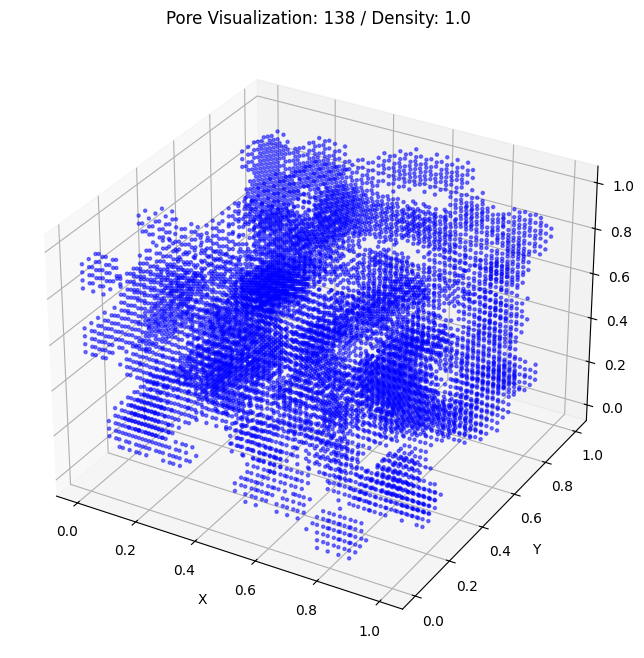

In [46]:
index = "138"
data_to_plot = data_dict[index]

# Extract only the points inside pores (occupancy == 1)
pores = data_to_plot[data_to_plot[:, 3] == 1]

# Extract x, y, z coordinates
x, y, z = pores[:, 0], pores[:, 1], pores[:, 2]

# Plot 3D scatter of pores
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5, s=5)  # Blue dots for pores

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Pore Visualization: {index} / Density: {densities_dict[index]}")

# Show the plot
plt.show()

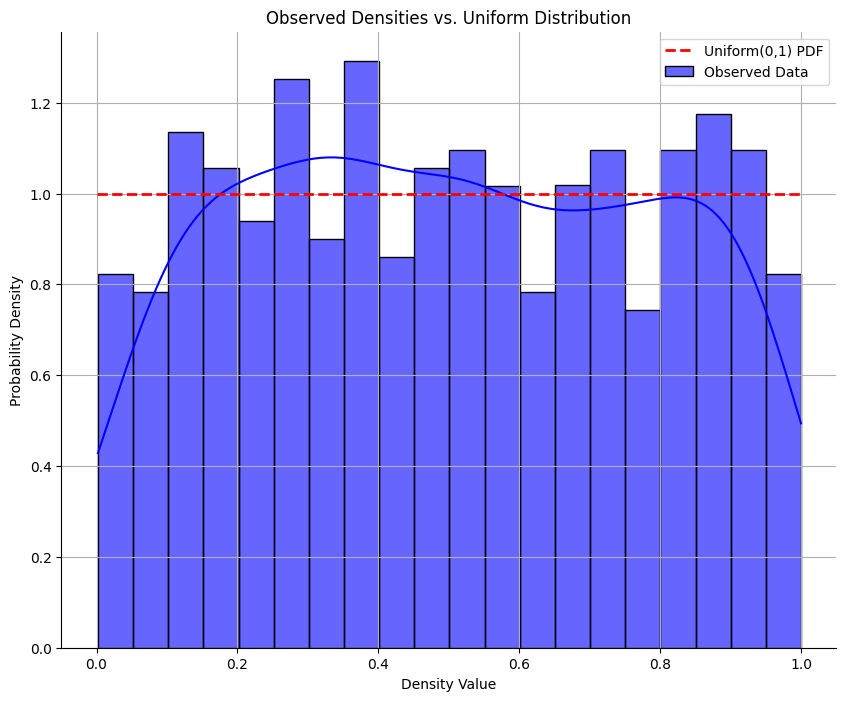

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

# Convert dictionary values to a NumPy array
density_values = np.array(list(densities_dict.values()))

# Generate the ideal uniform distribution PDF
x_range = np.linspace(0, 1, 100)
uniform_pdf = uniform.pdf(x_range, loc=0, scale=1)

# histogram of density values
plt.figure(figsize=(10, 8))
sns.histplot(density_values, bins=20, kde=True, stat="density", label="Observed Data", color="blue", alpha=0.6)

# uniform distribution
plt.plot(x_range, uniform_pdf, color="red", linestyle="dashed", linewidth=2, label="Uniform(0,1) PDF")


plt.xlabel("Density Value")
plt.ylabel("Probability Density")
plt.title("Observed Densities vs. Uniform Distribution")
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(True)
plt.show()

In [29]:
from scipy.stats import ks_1samp

# Perform KS test to verify if the distribution of densities is uniform
ks_stat, p_value = ks_1samp(density_values, uniform(loc=0, scale=1).cdf)
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("The data does not significantly differ from a uniform distribution (Fail to reject H0).")
else:
    print("The data significantly differs from a uniform distribution (Reject H0).")


P-value: 0.8784
The data does not significantly differ from a uniform distribution (Fail to reject H0).


****
# Fitting Density VS number of ones
****

Fitted Power-Law Function: Density = 0.0882 * (Number of Ones)^0.2632


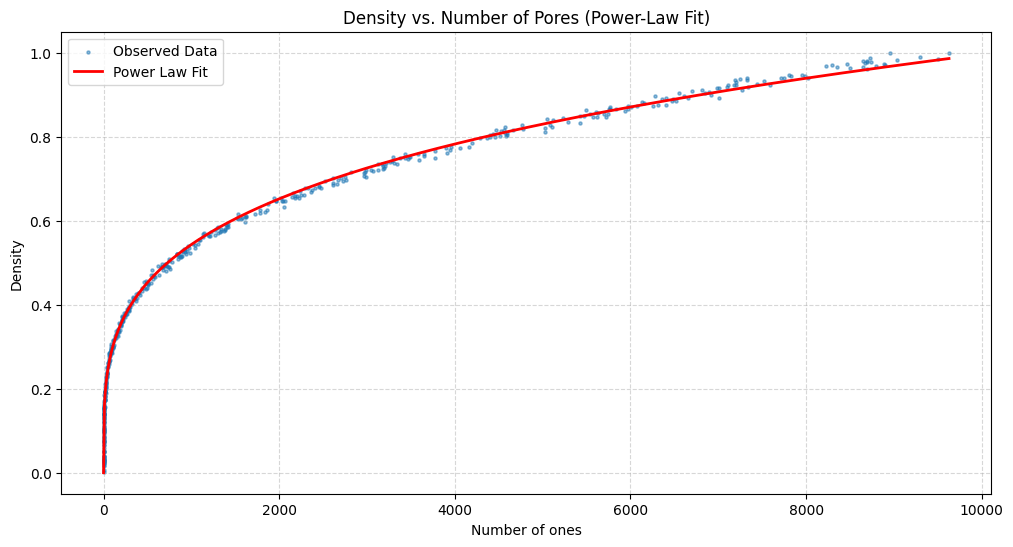

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ones = []
for _, values in grid_dict.items():
    ones.append(values.sum)
ones = np.array(ones)
density_values = np.array(density_values)

# Define a power-law function
def power_law(x, a, b):
    return a * x**b

# Fit the model using curve_fit
params, covariance = curve_fit(power_law, ones, density_values, maxfev=10000)
a_opt, b_opt = params
print(f"Fitted Power-Law Function: Density = {a_opt:.4f} * (Number of Ones)^{b_opt:.4f}")

# Generate fitted values
x_range = np.linspace(min(ones), max(ones), 1000)
y_fit = power_law(x_range, a_opt, b_opt)

# Plot Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(ones, density_values, marker='o', alpha=0.5, s=5, label="Observed Data")
ax.plot(x_range, y_fit, color="red", linewidth=2, label="Power Law Fit")

# Labels and Grid
ax.set_xlabel("Number of ones")
ax.set_ylabel("Density")
ax.set_title("Density vs. Number of Pores (Power-Law Fit)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Show plot
plt.show()

In [91]:
from sklearn.metrics import r2_score
y_pred = power_law(ones, a_opt, b_opt)
r2 = r2_score(density_values, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9963


****
# Model
****

In [2]:
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl

from models.vae import PoreDataset, VAE
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

dataset = PoreDataset(npy_files)
total_size = len(dataset)
val_size = int(total_size * 0.1)
train_size = total_size - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

# Train model
model = VAE(latent_dim=256, lr=1e-2, beta = 0)
trainer = pl.Trainer(max_epochs=200, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     log_every_n_steps=10,
                     callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best_reconstructor")
                     ]
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | encoder       | Sequential | 277 K  | train
1 | fc_mu         | Linear     | 2.1 M  | train
2 | fc_logvar     | Linear     | 2.1 M  | train
3 | decoder_input | Linear     | 2.1 M  | train
4 | decoder       | Sequential | 277 K  | train
-----------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.453    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 2:  41%|████      | 47/116 [00:04<00:07,  9.59it/s, v_num=1, train_loss_step=5.39e+4, val_loss=8.94e+4, train_loss_epoch=8.57e+4] 

: 

****
# Results
****

In [4]:
import pandas as pd
metrics = pd.read_csv(os.path.join(current_dir, "lightning_logs", "version_1", "metrics.csv"))

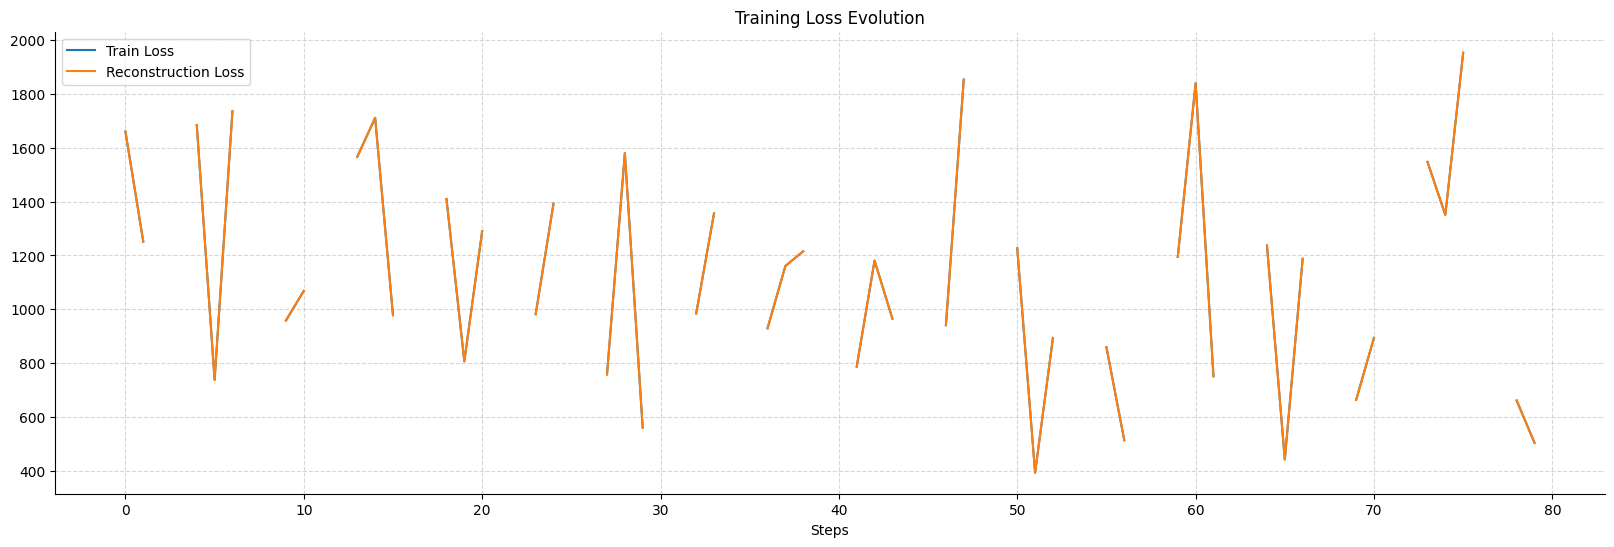

In [ ]:
import matplotlib.pyplot as plt

# Plot the original time series
plt.figure(figsize=(20, 6))
plt.plot(metrics["train_loss_step"], label='Train Loss')
plt.plot(metrics["reconstruction_loss"], label='Reconstruction Loss')
plt.plot(metrics["kl_divergence"], label='KL Divergence')
plt.title("Training Loss Evolution")
plt.xlabel('Steps')
plt.ylabel('')
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.ylim((0,100))
plt.legend()
plt.show()

In [11]:
ckpt_path = os.path.join(current_dir,"lightning_logs", "version_1", "checkpoints", "best_reconstructor.ckpt")
model_load = VAE(latent_dim=128,  beta = 0.1)
model_load.load_state_dict(torch.load(ckpt_path)["state_dict"])
model_load.eval()

VAE(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=8192, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=128, bias=True)
  (decoder_input): Linear(in_features=129, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (1): ReLU()
    (2): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(32, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
   

In [21]:
grid_test, d_test = dataset.__getitem__(138)
reco, mu1, logvar1 = model_load.forward(grid_test.unsqueeze(0), d_test.unsqueeze(0))
reco.sum()

tensor(8340.2197, grad_fn=<SumBackward0>)

In [ ]:
#TODO: Do a function that plot the grid and its reconstructed counter-part. Select the ones according to the k greatest proba with k given by the density model

The model learns probabilities that are extremely lows, and in the end we only have zeros. We have to modify the loss to be able to identify the ones more accurately. Moreover, we can fit a model between the density and the number of ones, so that the threshold is not arbitrarily 1 but the k greatest probabilities where k is given for a certain density. 

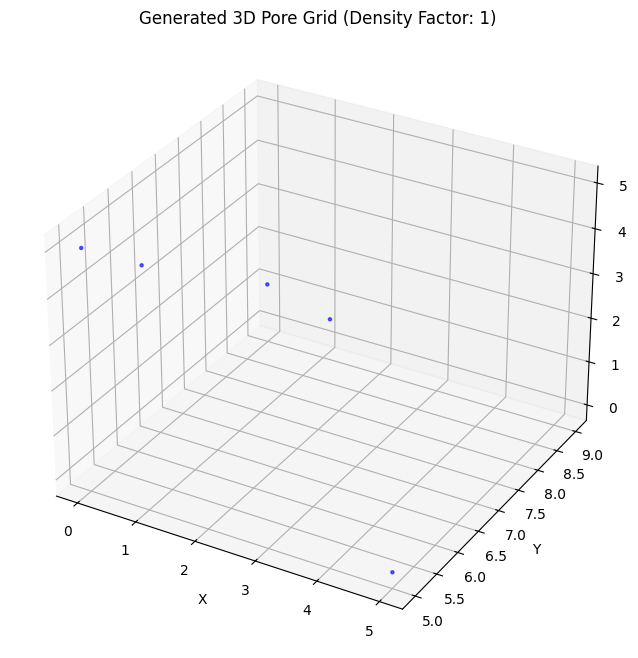

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_pore_grid(model, density_factor=0.3, random_sample=False):
    """
    Generates and visualizes a 3D pore structure using the trained VAE model.

    Parameters:
    - model: Trained VAE model
    - density_factor (float): The density value to condition the generation on
    - random_sample (bool): If True, samples a random latent vector
    """

    model.eval()  # Set to evaluation mode

    with torch.no_grad():
        # Sample a random latent vector or use mean latent representation
        latent_dim = model.latent_dim
        if random_sample:
            z = torch.randn(1, latent_dim)  # Random sampling
        else:
            z = torch.zeros(1, latent_dim)  # Use mean latent vector

        # Convert density factor to tensor
        density_tensor = torch.tensor([[density_factor]], dtype=torch.float32)

        # Generate 3D pore grid
        generated_grid = model.decode(z, density_tensor).squeeze().cpu().numpy()  # Shape: (30,30,30)

        # Threshold to obtain binary pore structure (0 or 1)
        binary_grid = (generated_grid > 0.5).astype(int)

        # Extract coordinates of pore locations (where grid == 1)
        x, y, z = np.where(binary_grid == 1)

        # Plot 3D scatter of pores
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c='blue', marker='o', alpha=0.6, s=5)

        # Labels & settings
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(f"Generated 3D Pore Grid (Density Factor: {density_factor})")
        plt.show()

visualize_pore_grid(model_load, density_factor=1, random_sample=True)